# SWF TDS:  Load AMSR data and collocate L1(TBs) + L2(SM + VOD) products.  

L1 product was downloaded from JAXA https://repo.gportal.jaxa.jp/standard/GCOM-W/GCOM-W.AMSR2/L3.TB18GHz_25/2/2020/12/  
(needs citation)  

L2 product was downloaded from EARTHDATA https://cmr.earthdata.nasa.gov/search/concepts/C1235316222-GES_DISC.html  
(needs authentification)



In [2]:
# imports
import os
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

# Al data soruces are in this folder:

data_folder = r"C:\Users\andre\Desktop\SM_TDS"

# Earth Data server is down, replace this with March 20th 2017 later.
sm_file_name = "LPRM-AMSR2_L3_A_SOILM3_V001_20170320000123.nc4"
tb36_file_name = "GW1AM2_20170320_01D_EQMA_L3SGT36LA2220220.h5"
tb18_file_name = "GW1AM2_20170320_01D_EQMA_L3SGT18LA2220220.h5"


In [3]:
sm_file = os.path.join(data_folder, sm_file_name)
sm_ds = xr.open_dataset(sm_file)
sm_ds

<xarray.Dataset> Size: 56MB
Dimensions:                 (Latitude: 720, Longitude: 1440)
Coordinates:
  * Latitude                (Latitude) float32 3kB 89.88 89.62 ... -89.62 -89.88
  * Longitude               (Longitude) float32 6kB -179.9 -179.6 ... 179.9
Data variables: (12/13)
    ts                      (Longitude, Latitude) float32 4MB ...
    soil_moisture_c1        (Longitude, Latitude) float32 4MB ...
    opt_depth_c1            (Longitude, Latitude) float32 4MB ...
    soil_moisture_c2        (Longitude, Latitude) float32 4MB ...
    opt_depth_c2            (Longitude, Latitude) float32 4MB ...
    soil_moisture_x         (Longitude, Latitude) float32 4MB ...
    ...                      ...
    mask                    (Longitude, Latitude) int16 2MB ...
    soil_moisture_c1_error  (Longitude, Latitude) float32 4MB ...
    soil_moisture_c2_error  (Longitude, Latitude) float32 4MB ...
    soil_moisture_x_error   (Longitude, Latitude) float32 4MB ...
    frequency_map           (Longitude, Latitude) float32 4MB ...
    scantime                (Longitude, Latitude) datetime64[ns] 8MB ...
Attributes:
    Conventions:  CF-1.0

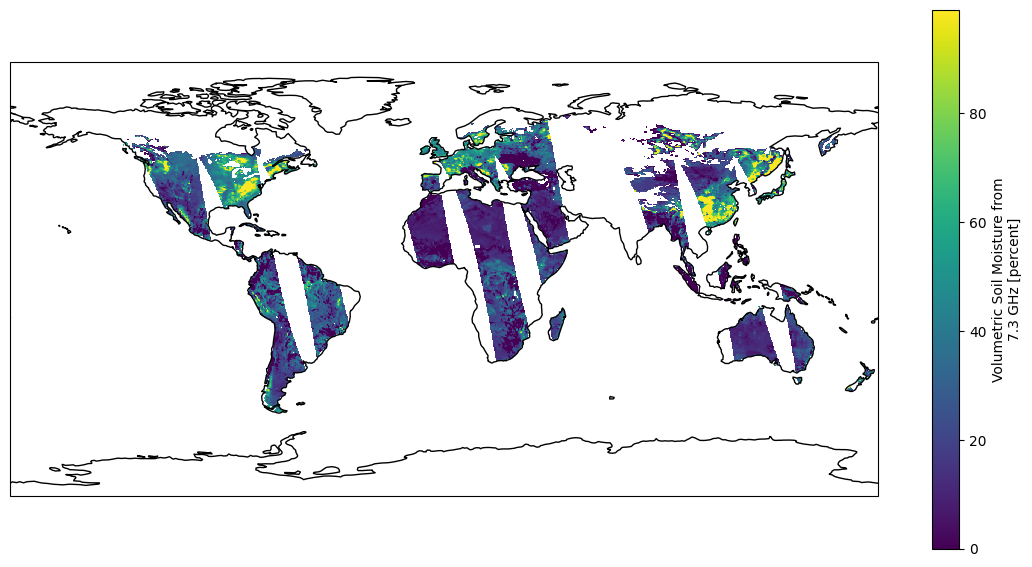

In [4]:
fig, ax = plt.subplots(1,1, figsize = (14,7), subplot_kw={"projection": ccrs.PlateCarree(central_longitude=0)})
sm_ds.soil_moisture_c2.plot(ax=ax, x="Longitude", y = "Latitude")
ax.coastlines("110m")

## TBs from JAXA website

<xarray.Dataset> Size: 25MB
Dimensions:                     (phony_dim_0: 720, phony_dim_1: 1440)
Coordinates:
  * phony_dim_0                 (phony_dim_0) int64 6kB 719 718 717 ... 2 1 0
Dimensions without coordinates: phony_dim_1
Data variables:
    Brightness Temperature (H)  (phony_dim_0, phony_dim_1) float64 8MB nan .....
    Brightness Temperature (V)  (phony_dim_0, phony_dim_1) float64 8MB nan .....
    Time Information            (phony_dim_0, phony_dim_1) float64 8MB -3.277...
Attributes: (12/25)
    ProductName:                   AMSR2-L3
    GeophysicalName:               Brightness Temperature (18GHz)
    MeanType:                      DayMean
    Projection:                    EQR
    Resolution:                    0.25deg
    ProductVersion:                2
    ...                            ...
    StartOrbitNumber:              25741
    StopOrbitNumber:               25756
    OrbitDirection:                Ascending
    PlatformShortName:             GCOM-W1
    SensorShortName:               AMSR2
    ECSDataModel:                  B.0

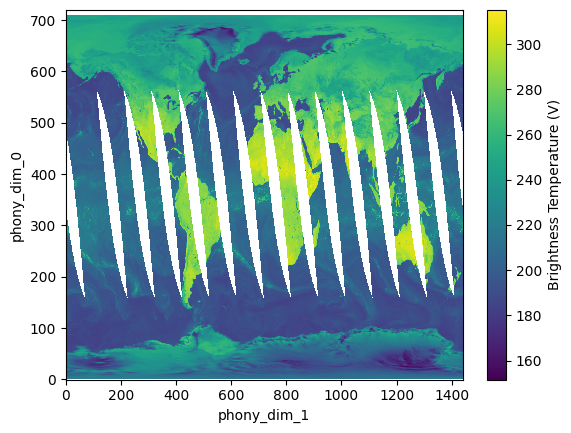

In [5]:
# 18HGz band:
tb18_ds = xr.open_dataset(os.path.join(data_folder, tb18_file_name))
# The Tbs have some scale factor:
for dvar in tb18_ds.data_vars:

    if "SCALE FACTOR" in tb18_ds[dvar].attrs.keys():
        # Remove missing values, set to 65534 (2**16 - 1)
        tb18_ds[dvar] = tb18_ds[dvar].where(tb18_ds[dvar] != 65534, np.nan)
        # Scale the tbs
        tb18_ds[dvar] = tb18_ds[dvar].attrs["SCALE FACTOR"] * tb18_ds[dvar]
        tb18_ds[dvar].attrs["SCALE FACTOR"] = 1

# Coordinate indeces transformation
# Revert latitude
tb18_ds = tb18_ds.reindex(phony_dim_0 = list(reversed(tb18_ds.phony_dim_0)))
# Roll longitude
tb18_ds = tb18_ds.roll({
    "phony_dim_1": 1440//2,
})

tb18_ds["Brightness Temperature (V)"].plot()
tb18_ds

<xarray.Dataset> Size: 25MB
Dimensions:                     (phony_dim_0: 720, phony_dim_1: 1440)
Coordinates:
  * phony_dim_0                 (phony_dim_0) int64 6kB 719 718 717 ... 2 1 0
Dimensions without coordinates: phony_dim_1
Data variables:
    Brightness Temperature (H)  (phony_dim_0, phony_dim_1) float64 8MB nan .....
    Brightness Temperature (V)  (phony_dim_0, phony_dim_1) float64 8MB nan .....
    Time Information            (phony_dim_0, phony_dim_1) float64 8MB -3.277...
Attributes: (12/25)
    ProductName:                   AMSR2-L3
    GeophysicalName:               Brightness Temperature (36GHz)
    MeanType:                      DayMean
    Projection:                    EQR
    Resolution:                    0.25deg
    ProductVersion:                2
    ...                            ...
    StartOrbitNumber:              25741
    StopOrbitNumber:               25756
    OrbitDirection:                Ascending
    PlatformShortName:             GCOM-W1
    SensorShortName:               AMSR2
    ECSDataModel:                  B.0

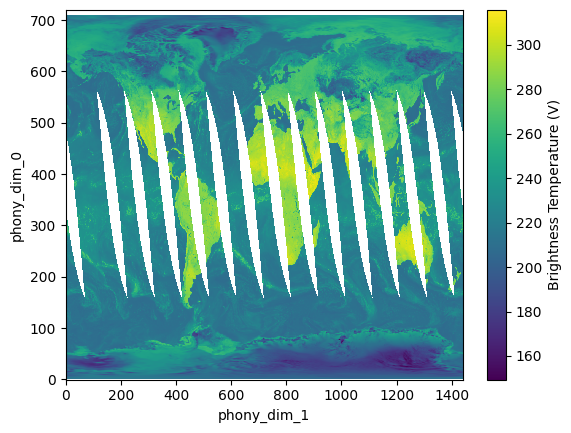

In [6]:
# Load and open the 36GHz file:
# 18HGz band:
tb37_ds = xr.open_dataset(os.path.join(data_folder, tb36_file_name))
# The Tbs have some scale factor:
for dvar in tb37_ds.data_vars:

    if "SCALE FACTOR" in tb37_ds[dvar].attrs.keys():
        # Remove missing values, set to 65534 (2**16 - 1)
        tb37_ds[dvar] = tb37_ds[dvar].where(tb37_ds[dvar] != 65534, np.nan)
        # Scale the tbs
        tb37_ds[dvar] = tb37_ds[dvar].attrs["SCALE FACTOR"] * tb37_ds[dvar]
        tb37_ds[dvar].attrs["SCALE FACTOR"] = 1

# Coordinate indeces transformation
# Revert latitude
tb37_ds = tb37_ds.reindex(phony_dim_0 = list(reversed(tb37_ds.phony_dim_0)))
# Roll longitude
tb37_ds = tb37_ds.roll({
    "phony_dim_1": 1440//2,
})

tb37_ds["Brightness Temperature (V)"].plot()
tb37_ds

In [7]:
# Try to fit TB and L2 files together:

sm_ds["TB36V"] = (("Latitude", "Longitude"), tb37_ds["Brightness Temperature (V)"].values)
sm_ds["TB36H"] = (("Latitude", "Longitude"), tb37_ds["Brightness Temperature (H)"].values)

sm_ds["TB18V"] = (("Latitude", "Longitude"), tb18_ds["Brightness Temperature (V)"].values)
sm_ds["TB18H"] = (("Latitude", "Longitude"), tb18_ds["Brightness Temperature (H)"].values)

# This layer sould be the same, also we are not using this anyways ... 
sm_ds["time_information"] = (("Latitude", "Longitude"), tb18_ds["Time Information"].values)

# Re write attrs

sm_ds.TB18H.attrs = tb18_ds["Brightness Temperature (H)"].attrs
sm_ds.TB18H.attrs = tb18_ds["Brightness Temperature (H)"].attrs
sm_ds.time_information.attrs = tb18_ds["Time Information"].attrs
sm_ds

<xarray.Dataset> Size: 97MB
Dimensions:                 (Latitude: 720, Longitude: 1440)
Coordinates:
  * Latitude                (Latitude) float32 3kB 89.88 89.62 ... -89.62 -89.88
  * Longitude               (Longitude) float32 6kB -179.9 -179.6 ... 179.9
Data variables: (12/18)
    ts                      (Longitude, Latitude) float32 4MB ...
    soil_moisture_c1        (Longitude, Latitude) float32 4MB ...
    opt_depth_c1            (Longitude, Latitude) float32 4MB ...
    soil_moisture_c2        (Longitude, Latitude) float32 4MB ...
    opt_depth_c2            (Longitude, Latitude) float32 4MB ...
    soil_moisture_x         (Longitude, Latitude) float32 4MB ...
    ...                      ...
    scantime                (Longitude, Latitude) datetime64[ns] 8MB ...
    TB36V                   (Latitude, Longitude) float64 8MB nan nan ... nan
    TB36H                   (Latitude, Longitude) float64 8MB nan nan ... nan
    TB18V                   (Latitude, Longitude) float64 8MB nan nan ... nan
    TB18H                   (Latitude, Longitude) float64 8MB nan nan ... nan
    time_information        (Latitude, Longitude) float64 8MB -3.277e+04 ... ...
Attributes:
    Conventions:  CF-1.0

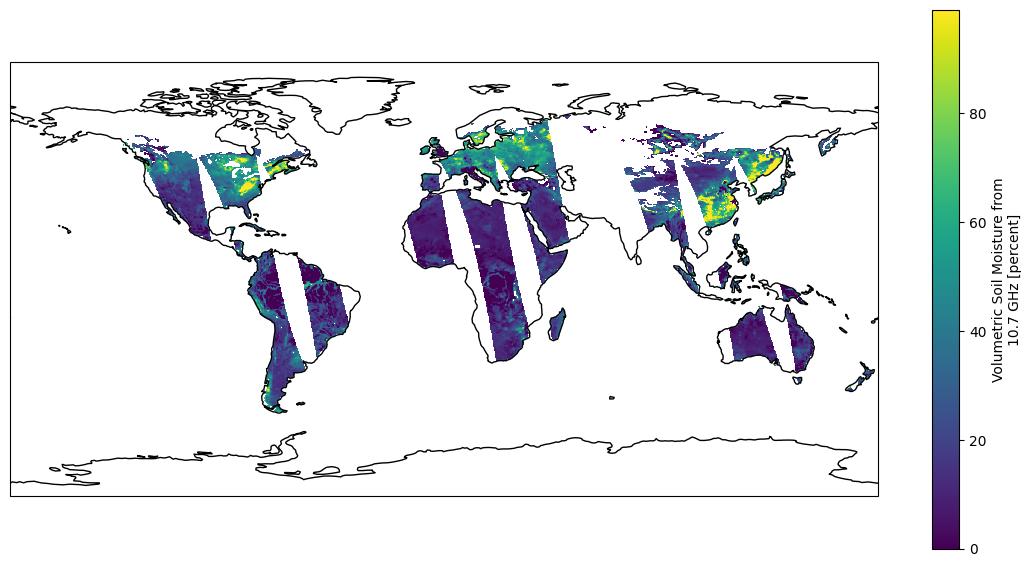

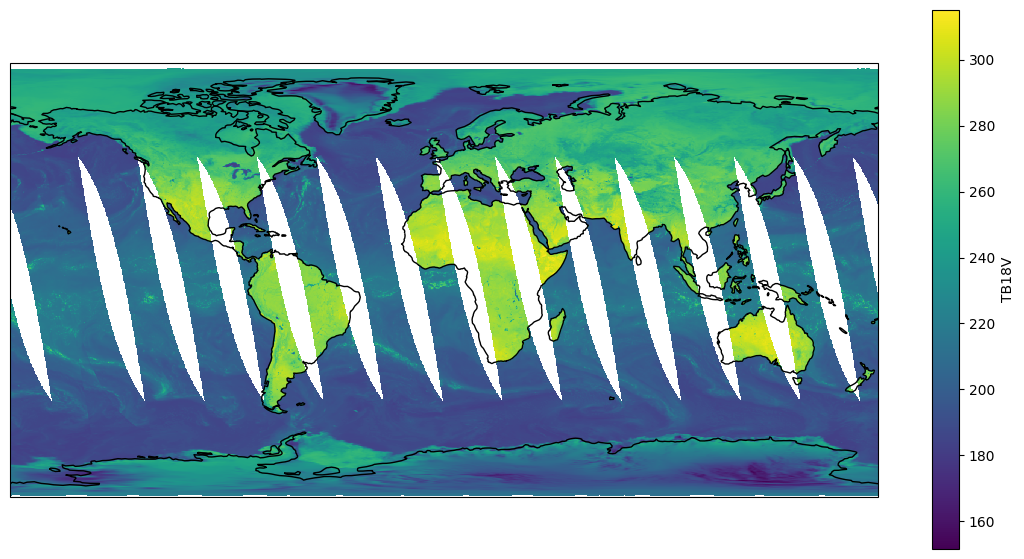

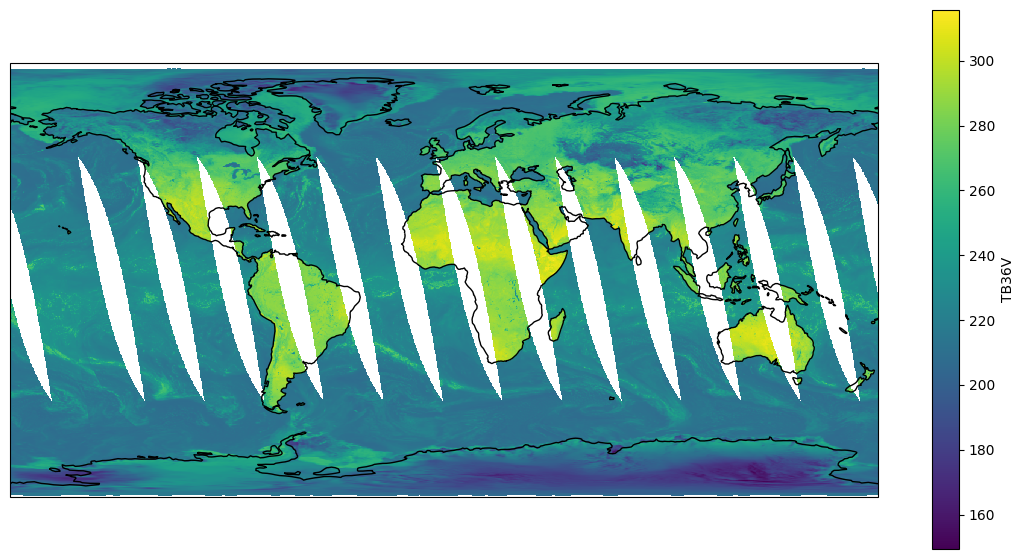

In [8]:
fig, ax = plt.subplots(1,1, figsize = (14,7), subplot_kw={"projection": ccrs.PlateCarree(central_longitude=0)})
sm_ds.soil_moisture_x.plot(ax=ax, x="Longitude", y = "Latitude")
ax.coastlines("110m")

fig, ax = plt.subplots(1,1, figsize = (14,7), subplot_kw={"projection": ccrs.PlateCarree(central_longitude=0)})
sm_ds.TB18V.plot(ax=ax, x="Longitude", y = "Latitude")
ax.coastlines("110m")

fig, ax = plt.subplots(1,1, figsize = (14,7), subplot_kw={"projection": ccrs.PlateCarree(central_longitude=0)})
sm_ds.TB36V.plot(ax=ax, x="Longitude", y = "Latitude")
ax.coastlines("110m")

In [9]:
# Re-add metadata for the Tbs since they were assigned by value.
sm_ds.TB18V.attrs = tb18_ds["Brightness Temperature (V)"].attrs
sm_ds.TB18H.attrs = tb18_ds["Brightness Temperature (H)"].attrs

sm_ds.TB36V.attrs = tb18_ds["Brightness Temperature (V)"].attrs
sm_ds.TB36H.attrs = tb18_ds["Brightness Temperature (H)"].attrs

# Add the sources to the dataset's metadata

sm_ds.attrs["long_name"] = """ 
Test dataset for CIMR L2PAD Surface Water Fraction product.
"""

sm_ds.attrs["data_sources"] = """ 
Brightness temperatures for 18 and 36 GHz (V and H polarizations): 
https://repo.gportal.jaxa.jp/standard/GCOM-W/

Soil Moisture and Optical Depth:
'https://disc.gsfc.nasa.gov/datasets/LPRM_AMSR2_A_SOILM3_001/summary?keywords=LPRM%20Soil%20moisture%20ascending'

"""
sm_ds

<xarray.Dataset> Size: 97MB
Dimensions:                 (Latitude: 720, Longitude: 1440)
Coordinates:
  * Latitude                (Latitude) float32 3kB 89.88 89.62 ... -89.62 -89.88
  * Longitude               (Longitude) float32 6kB -179.9 -179.6 ... 179.9
Data variables: (12/18)
    ts                      (Longitude, Latitude) float32 4MB ...
    soil_moisture_c1        (Longitude, Latitude) float32 4MB ...
    opt_depth_c1            (Longitude, Latitude) float32 4MB ...
    soil_moisture_c2        (Longitude, Latitude) float32 4MB ...
    opt_depth_c2            (Longitude, Latitude) float32 4MB ...
    soil_moisture_x         (Longitude, Latitude) float32 4MB ...
    ...                      ...
    scantime                (Longitude, Latitude) datetime64[ns] 8MB ...
    TB36V                   (Latitude, Longitude) float64 8MB nan nan ... nan
    TB36H                   (Latitude, Longitude) float64 8MB nan nan ... nan
    TB18V                   (Latitude, Longitude) float64 8MB nan nan ... nan
    TB18H                   (Latitude, Longitude) float64 8MB nan nan ... nan
    time_information        (Latitude, Longitude) float64 8MB -3.277e+04 ... ...
Attributes:
    Conventions:   CF-1.0
    long_name:      \nTest dataset for CIMR L2PAD Surface Water Fraction prod...
    data_sources:   \nBrightness temperatures for 18 and 36 GHz (V and H pola...

In [10]:
# Select some fields:

dvar_selection = [
    "soil_moisture_x",
    "opt_depth_x",
    "TB36V",
    "TB36H",
    "TB18V",
    "TB18H",
]

small_tds = sm_ds[dvar_selection]
small_tds

<xarray.Dataset> Size: 41MB
Dimensions:          (Longitude: 1440, Latitude: 720)
Coordinates:
  * Latitude         (Latitude) float32 3kB 89.88 89.62 89.38 ... -89.62 -89.88
  * Longitude        (Longitude) float32 6kB -179.9 -179.6 ... 179.6 179.9
Data variables:
    soil_moisture_x  (Longitude, Latitude) float32 4MB ...
    opt_depth_x      (Longitude, Latitude) float32 4MB ...
    TB36V            (Latitude, Longitude) float64 8MB nan nan nan ... nan nan
    TB36H            (Latitude, Longitude) float64 8MB nan nan nan ... nan nan
    TB18V            (Latitude, Longitude) float64 8MB nan nan nan ... nan nan
    TB18H            (Latitude, Longitude) float64 8MB nan nan nan ... nan nan
Attributes:
    Conventions:   CF-1.0
    long_name:      \nTest dataset for CIMR L2PAD Surface Water Fraction prod...
    data_sources:   \nBrightness temperatures for 18 and 36 GHz (V and H pola...

In [11]:
# Save TDS
save_path = os.path.join(data_folder, "CIMR_JNB_TDS_SWF.nc")
# sm_ds.to_netcdf(save_path)
small_tds.to_netcdf(save_path)

In [12]:
# TRy oppening it
tds = xr.open_dataset(save_path)
tds

<xarray.Dataset> Size: 41MB
Dimensions:          (Longitude: 1440, Latitude: 720)
Coordinates:
  * Latitude         (Latitude) float32 3kB 89.88 89.62 89.38 ... -89.62 -89.88
  * Longitude        (Longitude) float32 6kB -179.9 -179.6 ... 179.6 179.9
Data variables:
    soil_moisture_x  (Longitude, Latitude) float32 4MB ...
    opt_depth_x      (Longitude, Latitude) float32 4MB ...
    TB36V            (Latitude, Longitude) float64 8MB ...
    TB36H            (Latitude, Longitude) float64 8MB ...
    TB18V            (Latitude, Longitude) float64 8MB ...
    TB18H            (Latitude, Longitude) float64 8MB ...
Attributes:
    Conventions:   CF-1.0
    long_name:      \nTest dataset for CIMR L2PAD Surface Water Fraction prod...
    data_sources:   \nBrightness temperatures for 18 and 36 GHz (V and H pola...